<div class="alert alert-block alert-info">
<strong>Name and surname:


**Neil de la Fuente**</strong>
</div>



## Part 1. Supervised learning with the whole dataset

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

<u>Questions</u> (**2 points**):
1. **Split the dataset** into _train_ and _test_ subsets (60,000 images for _train_, and 10,000 for _test_)
2. Create a Convolutional Neural Network (**CNN**) with the following architecture:
- Convolutional layer (16 kernels, 5x5, ReLU activation
- Max pooling 2x2
- Fully-connected layer (10 neurons, Softmax activation)
3. **Train** this network with the whole _train_ subset with the following parameters:
- SGD optimizer
- Batch size equal to 100
- Number of epochs equal to 5
4. Provide (at least) the following **metrics** using the _test_ dataset:
- Accuracy
- F1 Score
- Confusion matrix

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

### **1.** Let´s import and split dataset and plot some samples

In [ ]:
# Import FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Print the shapes of the resulting datasets
print(f"Training data shape: {len(train_dataset)}")
print(f"Testing data shape: {len(test_dataset)}")



Training data shape: 60000
Testing data shape: 10000


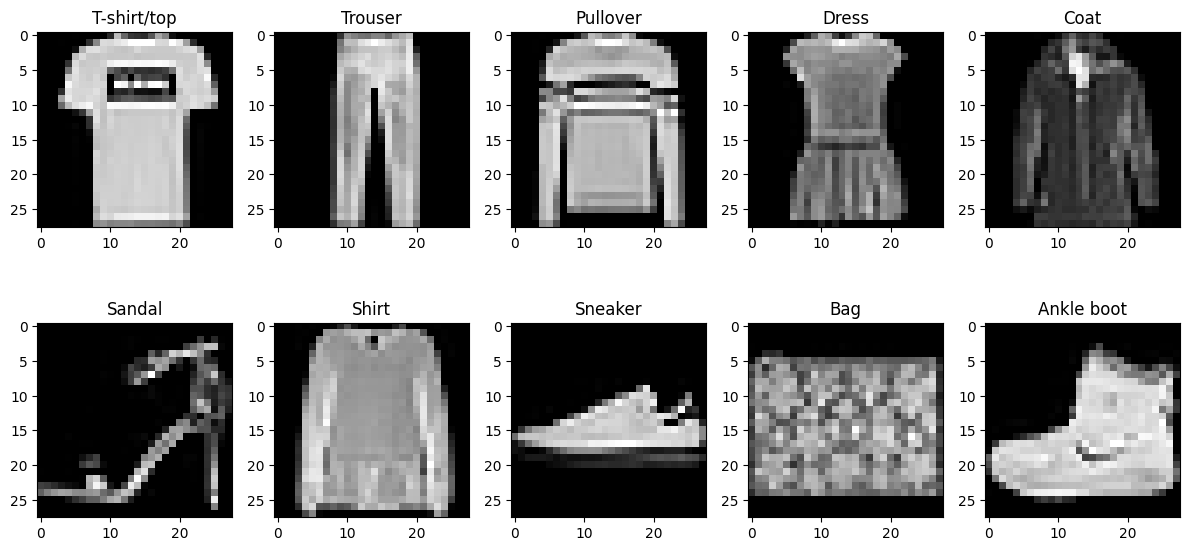

In [ ]:
labels = ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Get one image per label
label_images = [train_dataset.data[train_dataset.targets == label][0] for label in range(10)]

# Plot the images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(label_images[i], cmap='gray')
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()


### **2.** Convolutional Neural Network

Architcture:


*   Convolutional layer (16 kernels, 5x5, ReLU activation)
*   Max pooling 2x2
*   Fully-connected layer (10 neurons, Softmax activation)

In [ ]:
# @title auxiliary function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNN, self).__init__()

        self.conv = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(5,5)) #[batch_size, n_channels, 24, 24] (28 - 5 + 1 = 24)
        self.relu = nn.ReLU() #[batch_size, n_channels, 12, 12] (24 / 2 = 12)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))

        # Calculate in_features after flattening
        self.in_features_after_flatten = n_channels * 12 * 12
        self.fc = nn.Linear(in_features=self.in_features_after_flatten, out_features=n_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flatten the tensor
        x = x.view(x.size(0), self.in_features_after_flatten)
        x = self.fc(x)
        return x




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

n_classes = 10  # there are 10 classes
n_channels = 16

model = CNN(n_channels, n_classes)

print(f"Number of parameters: {get_n_params(model)}")


model.to(device)


criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

Number of parameters: 23466


In [ ]:
from tqdm import tqdm

@torch.no_grad()
@torch.no_grad()
def validate(criterion, model, loader):
    val_loss = 0
    model.eval()

    all_preds = []
    all_labels = []

    for data, target in tqdm(loader, desc="Validation", total=len(loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    val_loss /= len(loader)

    return val_loss, np.array(all_preds).flatten(), np.array(all_labels).flatten()



def train(epoch, criterion, model, optimizer, loader):
    total_loss = 0.0
    model.train()

    # Add tqdm here
    for batch_idx, (data, target) in tqdm(enumerate(loader), desc=f"Training Epoch {epoch+1}", total=len(loader)):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}')

        total_loss += loss.item()

    return total_loss / len(loader)  # Normalize by number of batches


Training Epoch 1:   0%|          | 3/600 [00:00<00:40, 14.72it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.509065


Training Epoch 1:  18%|█▊        | 107/600 [00:03<00:16, 29.70it/s]

Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.380360


Training Epoch 1:  34%|███▎      | 201/600 [00:07<00:14, 27.38it/s]

Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.559532


Training Epoch 1:  51%|█████     | 306/600 [00:14<00:10, 29.01it/s]

Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.628582


Training Epoch 1:  68%|██████▊   | 406/600 [00:18<00:07, 24.87it/s]

Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.437053


Training Epoch 1:  84%|████████▍ | 505/600 [00:22<00:03, 24.08it/s]

Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.656370


Validation: 100%|██████████| 100/100 [00:02<00:00, 42.48it/s]


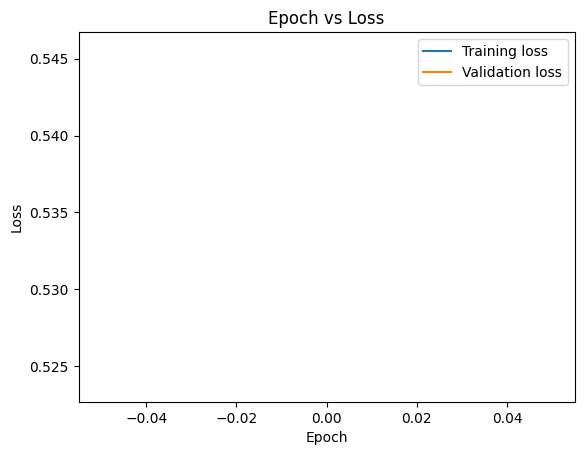

Training Epoch 2:   1%|          | 4/600 [00:00<00:29, 20.49it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.610583


Training Epoch 2:  18%|█▊        | 105/600 [00:03<00:17, 27.87it/s]

Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.484242


Training Epoch 2:  34%|███▍      | 204/600 [00:08<00:24, 16.47it/s]

Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.410109


Training Epoch 2:  51%|█████     | 305/600 [00:12<00:09, 29.86it/s]

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.346878


Training Epoch 2:  68%|██████▊   | 406/600 [00:15<00:06, 30.14it/s]

Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.370215


Training Epoch 2:  84%|████████▍ | 504/600 [00:19<00:03, 29.38it/s]

Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.428286


Validation: 100%|██████████| 100/100 [00:02<00:00, 42.19it/s]


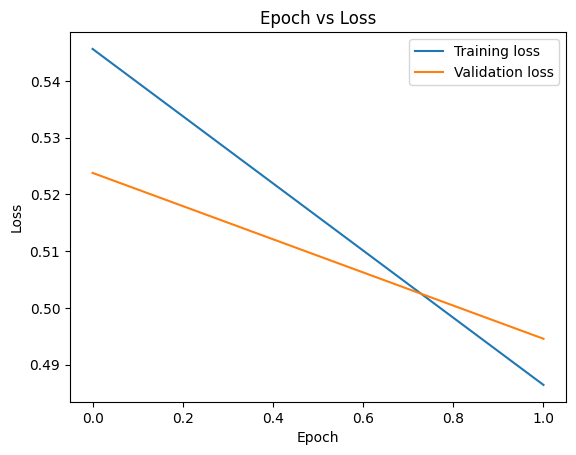

Training Epoch 3:   1%|          | 4/600 [00:00<00:29, 19.92it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.469004


Training Epoch 3:  18%|█▊        | 105/600 [00:03<00:16, 29.23it/s]

Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.493224


Training Epoch 3:  34%|███▍      | 203/600 [00:07<00:23, 17.23it/s]

Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.591170


Training Epoch 3:  51%|█████     | 306/600 [00:12<00:11, 26.67it/s]

Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.487042


Training Epoch 3:  68%|██████▊   | 405/600 [00:15<00:06, 29.94it/s]

Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.384279


Training Epoch 3:  84%|████████▍ | 506/600 [00:19<00:03, 29.94it/s]

Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.538048


Validation: 100%|██████████| 100/100 [00:02<00:00, 46.59it/s]


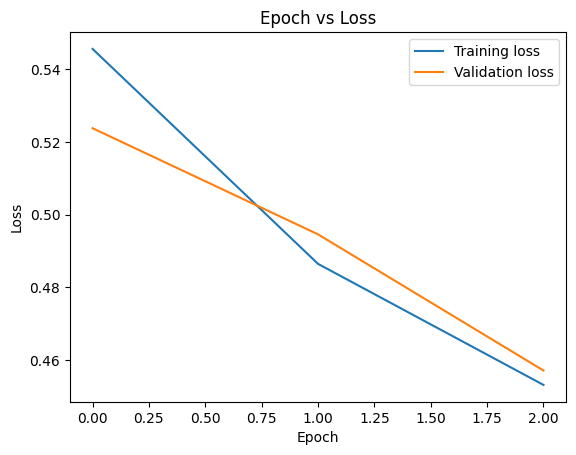

Training Epoch 4:   1%|          | 4/600 [00:00<00:28, 21.14it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.363907


Training Epoch 4:  18%|█▊        | 105/600 [00:03<00:18, 26.53it/s]

Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.405345


Training Epoch 4:  34%|███▍      | 204/600 [00:07<00:22, 17.84it/s]

Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.442821


Training Epoch 4:  51%|█████     | 307/600 [00:12<00:09, 30.36it/s]

Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.513514


Training Epoch 4:  68%|██████▊   | 405/600 [00:15<00:07, 27.05it/s]

Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.365945


Training Epoch 4:  84%|████████▍ | 506/600 [00:19<00:03, 27.02it/s]

Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.366391


Validation: 100%|██████████| 100/100 [00:02<00:00, 42.34it/s]


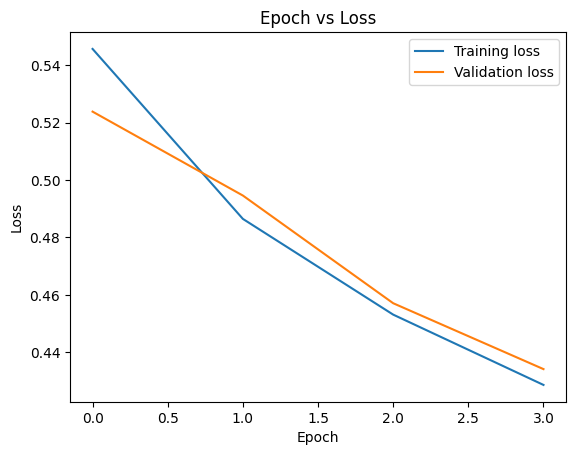

Training Epoch 5:   1%|          | 4/600 [00:00<00:29, 20.20it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.400672


Training Epoch 5:  18%|█▊        | 105/600 [00:03<00:18, 26.33it/s]

Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.498680


Training Epoch 5:  34%|███▎      | 202/600 [00:07<00:18, 21.21it/s]

Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.289357


Training Epoch 5:  51%|█████     | 305/600 [00:13<00:11, 25.41it/s]

Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.457683


Training Epoch 5:  68%|██████▊   | 405/600 [00:16<00:06, 29.02it/s]

Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.319502


Training Epoch 5:  84%|████████▍ | 504/600 [00:20<00:03, 29.97it/s]

Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.393542


Validation: 100%|██████████| 100/100 [00:02<00:00, 41.62it/s]


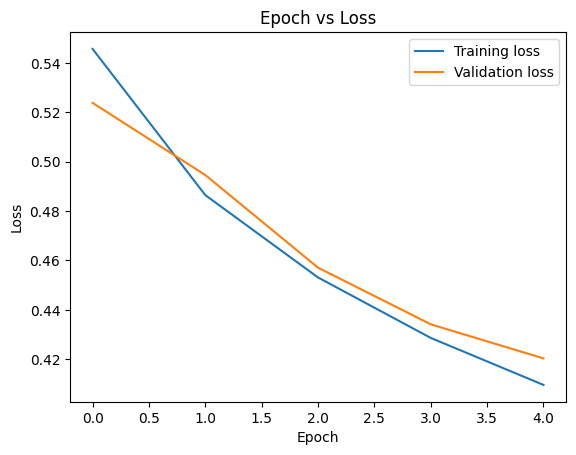

In [ ]:


best_val_loss = float('inf')
losses = {"train": [], "val": []}

for epoch in range(5):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss, preds, labels = validate(criterion, model, val_loader)

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Update plot every epoch (or consider doing this less often)
    plt.figure()
    plt.plot(losses["train"], label="Training loss")
    plt.plot(losses["val"], label="Validation loss")
    plt.title("Epoch vs Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.pause(0.000001)
    plt.show()





Validation: 100%|██████████| 100/100 [00:02<00:00, 42.23it/s]



Final Metrics:
Accuracy: 85.41%
Recall: 85.41%
F1-score: 85.27%


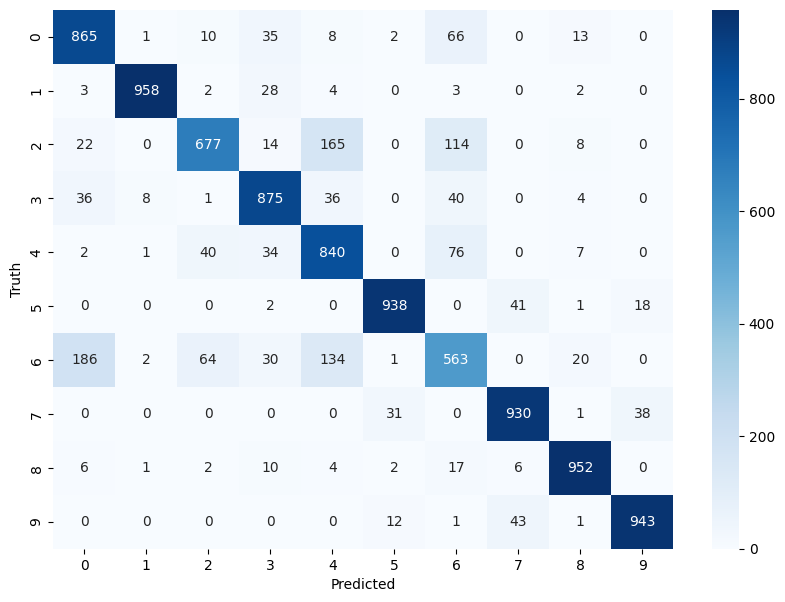

In [ ]:
final_val_loss, all_preds, all_labels = validate(criterion, model, val_loader)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
cm = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f'\nFinal Metrics:')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1-score: {f1*100:.2f}%')

# Plot confusion matrix using
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## **CONCLUSIONS OF EXERCISE 1**

We have trained a classifier on the whole training set and evaluated it, we can see wuite good results, which are denoted in previous cell, but as a summary we got:


*   Accuracy: 85.41%
*   Recall: 85.41%
*   F1-score: 85.27%